### packages

In [1]:
########################################################################################################
########################################################################################################


from MADDPG import MADDPG

########################################################################################################
########################################################################################################


import os

import numpy as np

########################################################################################################
########################################################################################################


import torch

########################################################################################################
########################################################################################################


import matplotlib.pyplot as plt 

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

########################################################################################################
########################################################################################################


from Environment import Environment


### load the environment

In [2]:
########################################################################################################
########################################################################################################

env=Environment()

obs = env.reset()

########################################################################################################
########################################################################################################

obs_dim_list=[len(o) for o in obs]

########################################################################################################
########################################################################################################

act_dim_list=[2 for o in obs]

########################################################################################################
########################################################################################################

res_dir="./result"

########################################################################################################
########################################################################################################


### maddpg algorithm

In [3]:
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

class argparse(object):
    
    buffer_capacity=int(1e6)
    
    actor_lr=1e-2
    
    critic_lr=1e-2
    
    episode_num=30000
    
    steps_before_learn=2000
    
    batch_size=1024
    
    gamma=.95
    
    tau=.02
    
    episode_length=25
    
    learn_interval=100
    
    save_interval=100
    
args=argparse()

########################################################################################################
########################################################################################################

maddpg = MADDPG(obs_dim_list, act_dim_list, args.buffer_capacity, args.actor_lr, args.critic_lr, res_dir)

########################################################################################################
########################################################################################################


total_step = 0

total_reward = np.zeros((args.episode_num, len(env.agents)))  # reward of each agent in each episode


training on device: cpu


### training

In [ ]:
########################################################################################################
########################################################################################################


for episode in range(args.episode_num):
    
    obs = env.reset()
    
    # record reward of each agent in this episode
    
    episode_reward = np.zeros((args.episode_length, len(env.agents)))
    
    for step in range(args.episode_length):  # interact with the env for an episode
        
        actions = maddpg.select_action(obs)
        
        ########################################################################################################
        
        actual_actions=list()
        
        for i in range(len(env.agents)):
            
            action=actions[i]
            
            velocity=env.agents[i].velocity*action[0]
            
            theta=2*np.pi**action[1]
            
            actual_actions.append((velocity,theta))
        
        ########################################################################################################
        
        next_obs, rewards, dones , _ = env.step(actual_actions)
        

        #env.render()# show
        
        episode_reward[step] = rewards
        
        total_step += 1

        maddpg.add(obs, actions, rewards, next_obs, dones)
        
        # only start to learn when there are enough experiences to sample
        
        if total_step > args.steps_before_learn:
            
            if total_step % args.learn_interval == 0:
                
                maddpg.learn(args.batch_size, args.gamma)
                
                maddpg.update_target(args.tau)
                
            if episode % args.save_interval == 0:
                
                torch.save([agent.actor.state_dict() for agent in maddpg.agents],\
                           os.path.join(res_dir, f'model_{episode}.pt'))

        obs = next_obs
        

    # episode finishes
    
    # calculate cumulative reward of each agent in this episode
    
    cumulative_reward = episode_reward.sum(axis=0)
    
    total_reward[episode] = cumulative_reward
    
    if episode%100==0:
    
        print(f'episode {episode + 1}: cumulative reward: {cumulative_reward}, '

              f'sum reward: {sum(cumulative_reward)}')

########################################################################################################
########################################################################################################

# all episodes performed, training finishes
# save agent parameters

torch.save([agent.actor.state_dict() for agent in maddpg.agents], os.path.join(res_dir, 'model.pt'))

# save training reward

np.save(os.path.join(res_dir, 'rewards.npy'), total_reward)


episode 1: cumulative reward: [-131.21105639  -61.61162636  -62.15528417  -53.25766488 -138.24365229
   54.72086297], sum reward: -391.7584211234338
episode 101: cumulative reward: [-154.70620485 -198.5361875  -223.08611061 -104.72148778  -16.30459198
  141.89762367], sum reward: -555.4569590445335


### training curve

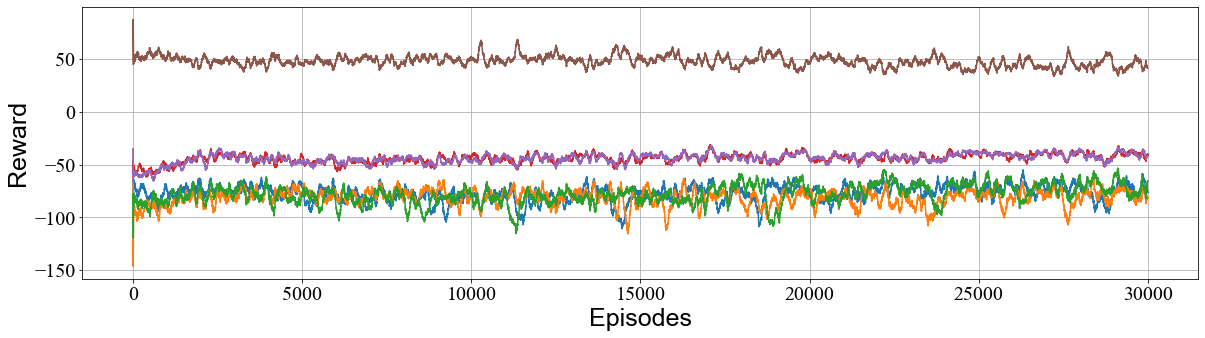

In [11]:
total_reward=np.load(res_dir+"/rewards.npy")

def get_running_reward(reward_array: np.ndarray, window=100):
    
    """calculate the running reward, i.e. average of last `window` elements from rewards"""
    
    running_reward = np.zeros_like(reward_array)
    
    for i in range(window - 1):
        
        running_reward[i] = np.mean(reward_array[:i + 1])
        
    for i in range(window - 1, len(reward_array)):
        
        running_reward[i] = np.mean(reward_array[i - window + 1:i + 1])
        
    return running_reward

########################################################################################################
########################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(figsize = (20,5))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

axs.grid()

########################################################################################################
########################################################################################################

x = range(1, args.episode_num + 1)

for agent in range(len(env.agents)):
    
#     axs.plot(x, total_reward[:, agent], label=agent)
    
    axs.plot(x, get_running_reward(total_reward[:, agent]))
    
########################################################################################################
########################################################################################################

axs.set_xlabel('Episodes',font_label)

axs.set_ylabel('Reward',font_label)

plt.show()